### Introduccion
Implementar un modelo de ML para clasificar si un dominio es legítimo o es Phishing. El phising se basa en la ingeniería social (manipulación de emociones, aprovechamiento de atajos mentales y sesgos cognitivos) para engañar a las víctimas y lograr que estas den información (normalmente credenciales).

## Parte I --- Ingeniería de características

### Explotación de datos

1. Cargue el dataset en un dataframe de pandas, muestre un ejemplo de cinco observaciones.

In [1]:
import pandas as pd

data = pd.read_csv('data/dataset_phishing.csv')
data.head(5)

,url,status
0,http://www.crestonwood.com/router.php,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,phishing
2,https://support-appleld.com.secureupdate.duila...,phishing
3,http://rgipt.ac.in,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate


2. Muestre la cantidad de observaciones etiquetadas en la columna status como “legit” y como “pishing”. ¿Está balanceado el dataset?

In [2]:
print(data['status'].value_counts())

status
legitimate    5715
phishing      5715
Name: count, dtype: int64


### Derivación de características

1. ¿Qué ventajas tiene el análisis de una URL contra el análisis de otros datos, cómo el tiempo de vida del dominio, o las características de la página Web?

- El análisis de una URL tiene varias ventajas importantes frente a otros tipos de análisis. En primer lugar, es mucho más rápido y ligero, ya que no requiere cargar ni inspeccionar el contenido completo de una página web. Esto permite detectar phishing en tiempo real, incluso antes de que el usuario acceda al sitio. Además, el análisis de URL no depende de servicios externos ni del historial del dominio, lo que lo hace más independiente y resistente ante ataques nuevos. También es más seguro, porque evita interactuar directamente con páginas que pueden ser maliciosas.


2. ¿Qué características de una URL son más prometedoras para la detección de phishing?

- Las características más prometedoras de una URL para detectar phishing son aquellas relacionadas con su estructura y composición. Entre las más útiles se encuentran la longitud de la URL, la cantidad de subdominios, el uso de direcciones IP en lugar de nombres de dominio, la presencia de caracteres especiales, y patrones sospechosos como guiones o múltiples puntos. También resultan muy relevantes las características léxicas y estadísticas, como la frecuencia de símbolos no alfanuméricos o la entropía de estos caracteres. Estas propiedades suelen diferenciar claramente una URL legítima de una maliciosa y permiten a los modelos de machine learning identificar phishing con alta precisión.

### Preprocesamiento
Funciones basadas en los artículos, para derivar características que un modelo pueda utilizar incluidas la entropía de Shanon y relativa

In [3]:
import re
import math
from urllib.parse import urlparse

# 1. Longitud total de la URL
def url_length(url):
    return len(url)

# 2. Número de dígitos en la URL
def digits_len(url):
    return sum(c.isdigit() for c in url)

# 3. Número de subdominios
def num_subdomains(url):
    domain = urlparse(url).netloc
    return domain.count('.') - 1

# 4. Longitud del dominio
def domain_length(url):
    return len(urlparse(url).netloc)

# 5. Longitud del path
def path_length(url):
    return len(urlparse(url).path)

# 6. Presencia de dirección IP
def has_ip(url):
    ip_pattern = r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b'
    return 1 if re.search(ip_pattern, url) else 0

# 7. Uso de HTTPS
def uses_https(url):
    return 1 if url.startswith('https') else 0

# 8. Conteo de guiones
def count_hyphens(url):
    return url.count('-')

# 9. Conteo de arrobas (@)
def count_at(url):
    return url.count('@')

# 10. Conteo de puntos
def count_dots(url):
    return url.count('.')

# 11. Palabras sospechosas
def suspicious_words(url):
    words = ['login', 'secure', 'update', 'verify', 'account', 'bank']
    return sum(url.lower().count(word) for word in words)

# 12. Proporción de dígitos
def digit_ratio(url):
    return digits_len(url) / len(url)

# 13. Conteo de caracteres especiales
def special_char_count(url):
    return sum(not c.isalnum() for c in url)

# 14. Entropía de Shannon
def shannon_entropy(url):
    freq = {}
    for c in url:
        freq[c] = freq.get(c, 0) + 1
    entropy = 0
    length = len(url)
    for char in freq:
        p = freq[char] / length
        entropy -= p * math.log2(p)
    return entropy

# 15. Entropía relativa
def relative_entropy(url):
    unique_chars = len(set(url))
    max_entropy = math.log2(unique_chars) if unique_chars > 0 else 1
    return shannon_entropy(url) / max_entropy if max_entropy > 0 else 0

### Aplicando las características

In [4]:
data['url_length'] = data['url'].apply(url_length)

data['digits_len'] = data['url'].apply(digits_len)

data['num_subdomains'] = data['url'].apply(num_subdomains)

data['domain_length'] = data['url'].apply(domain_length)

data['path_length'] = data['url'].apply(path_length)

data['has_ip'] = data['url'].apply(has_ip)

data['uses_https'] = data['url'].apply(uses_https)

data['count_hyphens'] = data['url'].apply(count_hyphens)

data['count_at'] = data['url'].apply(count_at)

data['count_dots'] = data['url'].apply(count_dots)

data['suspicious_words'] = data['url'].apply(suspicious_words)

data['digit_ratio'] = data['url'].apply(digit_ratio)

data['special_char_count'] = data['url'].apply(special_char_count)

data['shannon_entropy'] = data['url'].apply(shannon_entropy)

data['relative_entropy'] = data['url'].apply(relative_entropy)

# Verificar las nuevas columnas
data.head(5)

,url,status,url_length,digits_len,num_subdomains,domain_length,path_length,has_ip,uses_https,count_hyphens,count_at,count_dots,suspicious_words,digit_ratio,special_char_count,shannon_entropy,relative_entropy
0,http://www.crestonwood.com/router.php,legitimate,37,0,1,19,11,0,0,0,0,3,0,0.000000,7,3.787043,0.946761
1,http://shadetreetechnology.com/V4/validation/a...,phishing,77,17,0,23,47,0,0,0,0,1,0,0.220779,7,4.419864,0.909815
2,https://support-appleld.com.secureupdate.duila...,phishing,126,19,3,50,20,0,1,1,0,4,3,0.150794,19,4.753412,0.942316
3,http://rgipt.ac.in,legitimate,18,0,1,11,0,0,0,0,0,2,0,0.000000,5,3.461320,0.965511
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate,55,0,1,15,33,0,0,2,0,2,0,0.000000,10,4.097662,0.948110


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   url                 11430 non-null  object 
 1   status              11430 non-null  object 
 2   url_length          11430 non-null  int64  
 3   digits_len          11430 non-null  int64  
 4   num_subdomains      11430 non-null  int64  
 5   domain_length       11430 non-null  int64  
 6   path_length         11430 non-null  int64  
 7   has_ip              11430 non-null  int64  
 8   uses_https          11430 non-null  int64  
 9   count_hyphens       11430 non-null  int64  
 10  count_at            11430 non-null  int64  
 11  count_dots          11430 non-null  int64  
 12  suspicious_words    11430 non-null  int64  
 13  digit_ratio         11430 non-null  float64
 14  special_char_count  11430 non-null  int64  
 15  shannon_entropy     11430 non-null  float64
 16  rela


### Convertir status en una variable binaria 
- 1 = phising
- 0 = legitima

In [6]:
data['status'] = data['status'].map({'phishing': 1, 'legitimate': 0})
print(data['status'].value_counts())

status
0    5715
1    5715
Name: count, dtype: int64


### Borrando la columna de dominio y guardando el nuevo data set.

In [7]:
new_data = data.drop(columns=['url'])

# Verificar estructura
new_data.head()

,status,url_length,digits_len,num_subdomains,domain_length,path_length,has_ip,uses_https,count_hyphens,count_at,count_dots,suspicious_words,digit_ratio,special_char_count,shannon_entropy,relative_entropy
0,0,37,0,1,19,11,0,0,0,0,3,0,0.000000,7,3.787043,0.946761
1,1,77,17,0,23,47,0,0,0,0,1,0,0.220779,7,4.419864,0.909815
2,1,126,19,3,50,20,0,1,1,0,4,3,0.150794,19,4.753412,0.942316
3,0,18,0,1,11,0,0,0,0,0,2,0,0.000000,5,3.461320,0.965511
4,0,55,0,1,15,33,0,0,2,0,2,0,0.000000,10,4.097662,0.948110


In [8]:
new_data.to_csv('data/new_dataset_phishing.csv', index=False)

### Selección de características

In [9]:
print("Dimensiones del dataset:")
print(new_data.shape)

Dimensiones del dataset:
(11430, 16)


In [10]:
# Verificar observaciones duplicadas

print("\nNúmero de filas duplicadas:")
print(new_data.duplicated().sum())




Número de filas duplicadas:
710


In [11]:
new_data = new_data.drop_duplicates()
print("\nDuplicados eliminados. Nuevo tamaño:")
print(new_data.shape)


Duplicados eliminados. Nuevo tamaño:
(10720, 16)


In [12]:
print("\n--- Columnas con un solo valor único (constantes) ---")

constant_columns = [col for col in new_data.columns if new_data[col].nunique() == 1]

print(constant_columns)


--- Columnas con un solo valor único (constantes) ---
[]


In [13]:
print("\n--- Varianza de cada columna ---")

variances = new_data.var()

print(variances.sort_values())

low_variance = variances[variances < 0.01].index.tolist()

print("\nColumnas con varianza muy baja:")
print(low_variance)

new_data = new_data.drop(columns=low_variance)
print("\nColumnas de baja varianza eliminadas.")


--- Varianza de cada columna ---
relative_entropy         0.000283
digit_ratio              0.008261
has_ip                   0.009242
count_at                 0.025747
shannon_entropy          0.167577
uses_https               0.235429
status                   0.249539
suspicious_words         0.431894
num_subdomains           0.782136
count_dots               1.973426
count_hyphens            4.576577
special_char_count      37.986553
domain_length          120.902787
digits_len             281.980021
path_length            787.917047
url_length            3171.660155
dtype: float64

Columnas con varianza muy baja:
['has_ip', 'digit_ratio', 'relative_entropy']

Columnas de baja varianza eliminadas.


In [14]:
print("\n--- Correlación con status ---")

correlation = new_data.corr()['status'].sort_values()

print(correlation)


--- Correlación con status ---
count_hyphens        -0.127220
uses_https           -0.094682
path_length           0.075443
num_subdomains        0.102832
count_at              0.141306
special_char_count    0.177000
count_dots            0.199070
domain_length         0.226412
url_length            0.228687
digits_len            0.233538
suspicious_words      0.295657
shannon_entropy       0.309567
status                1.000000
Name: status, dtype: float64


### Seleccionado características poco correlacionadas

In [15]:
irrelevant = correlation[abs(correlation) < 0.05].index.tolist()

print("\nColumnas con correlación muy baja con status:")
print(irrelevant)


Columnas con correlación muy baja con status:
[]


In [16]:
print("\n--- Búsqueda de características altamente correlacionadas ---")

corr_matrix = new_data.corr()

to_drop = set()

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.95:
            colname = corr_matrix.columns[i]
            to_drop.add(colname)

print("\nColumnas altamente correlacionadas entre sí:")
print(to_drop)


--- Búsqueda de características altamente correlacionadas ---

Columnas altamente correlacionadas entre sí:
set()


In [17]:
print("\n--- DATASET FINAL ---")
print("Dimensiones:", new_data.shape)
print("Columnas finales:", new_data.columns)
print("\nVista previa:")
print(new_data.head())
new_data.to_csv('data/new_clean_dataset_phishing.csv', index=False)


--- DATASET FINAL ---
Dimensiones: (10720, 13)
Columnas finales: Index(['status', 'url_length', 'digits_len', 'num_subdomains', 'domain_length',
       'path_length', 'uses_https', 'count_hyphens', 'count_at', 'count_dots',
       'suspicious_words', 'special_char_count', 'shannon_entropy'],
      dtype='object')

Vista previa:
   status  url_length  digits_len  num_subdomains  domain_length  path_length  \
0       0          37           0               1             19           11   
1       1          77          17               0             23           47   
2       1         126          19               3             50           20   
3       0          18           0               1             11            0   
4       0          55           0               1             15           33   

   uses_https  count_hyphens  count_at  count_dots  suspicious_words  \
0           0              0         0           3                 0   
1           0              0         0

### Columnas seleccionadas

Después del proceso de exploración y limpieza, el dataset quedó con estas 13 características:

['status',
 'url_length',
 'digits_len',
 'num_subdomains',
 'domain_length',
 'path_length',
 'uses_https',
 'count_hyphens',
 'count_at',
 'count_dots',
 'suspicious_words',
 'special_char_count',
 'shannon_entropy']

Se tomaron en cuenta ya que:
- Ninguna de estas columnas tiene un solo valor único. Todas varían entre las URLs, por lo tanto aportan información útil para diferenciar entre phishing y legítimas.
- Tienen varianza suficientemente alta
- Representan patrones relevantes para phishing


## Pate 2 - Implementación

In [18]:
cleaned_data = pd.read_csv('data/new_clean_dataset_phishing.csv')
cleaned_data.shape

(10720, 13)

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score

sns.set_theme(style='whitegrid')


### Separación de datos (55% / 15% / 30%)
Se utiliza una separación estratificada para conservar la proporción de clases (phishing vs legítimo) en todos los subconjuntos.


In [20]:
df_model = pd.read_csv('data/new_clean_dataset_phishing.csv').copy()

X = df_model.drop(columns=['status'])
y = df_model['status']

# 30% para prueba, 70% temporal para entrenamiento + validación
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

# Del 70% temporal, se toma una fracción para que validación sea 15% del total
val_ratio = 0.15 / 0.70
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=val_ratio,
    random_state=42,
    stratify=y_train_val
)

train_df = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
val_df = pd.concat([X_val.reset_index(drop=True), y_val.reset_index(drop=True)], axis=1)
test_df = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)

train_df.to_csv('data/train_phishing.csv', index=False)
val_df.to_csv('data/validation_phishing.csv', index=False)
test_df.to_csv('data/test_phishing.csv', index=False)

total = len(df_model)
print(f'Total: {total}')
print(f'Train: {len(train_df)} ({len(train_df)/total:.2%})')
print(f'Validación: {len(val_df)} ({len(val_df)/total:.2%})')
print(f'Prueba: {len(test_df)} ({len(test_df)/total:.2%})')

print() 
print('Distribución de clase por partición:')
print('Train:')
print(train_df['status'].value_counts(normalize=True).round(3))
print('Validación:')
print(val_df['status'].value_counts(normalize=True).round(3))
print('Prueba:')
print(test_df['status'].value_counts(normalize=True).round(3))


Total: 10720
Train: 5895 (54.99%)
Validación: 1609 (15.01%)
Prueba: 3216 (30.00%)

Distribución de clase por partición:
Train:
status
1    0.522
0    0.478
Name: proportion, dtype: float64
Validación:
status
1    0.522
0    0.478
Name: proportion, dtype: float64
Prueba:
status
1    0.522
0    0.478
Name: proportion, dtype: float64


### Entrenamiento de modelos
Se entrenan dos modelos con enfoques distintos: uno lineal (Regresión Logística) y uno basado en ensambles de árboles (Random Forest).


In [21]:
models = {
    'Regresión Logística': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=2000, random_state=42))
    ]),
    'Random Forest': RandomForestClassifier(
        n_estimators=400,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    )
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(f'Modelo entrenado: {name}')


Modelo entrenado: Regresión Logística
Modelo entrenado: Random Forest


### Evaluación en validación y prueba
Se calculan las métricas requeridas para comparar modelos en el contexto de detección de phishing.


In [22]:
def evaluate_model(model, X_data, y_data):
    y_pred = model.predict(X_data)
    y_proba = model.predict_proba(X_data)[:, 1]

    cm = confusion_matrix(y_data, y_pred)
    precision = precision_score(y_data, y_pred)
    recall = recall_score(y_data, y_pred)
    auc = roc_auc_score(y_data, y_proba)
    fpr, tpr, _ = roc_curve(y_data, y_proba)

    return {
        'cm': cm,
        'precision': precision,
        'recall': recall,
        'auc': auc,
        'fpr': fpr,
        'tpr': tpr
    }

results = {}
rows = []

for model_name, model in models.items():
    results[model_name] = {}
    for split_name, X_split, y_split in [
        ('validación', X_val, y_val),
        ('prueba', X_test, y_test)
    ]:
        metrics = evaluate_model(model, X_split, y_split)
        results[model_name][split_name] = metrics

        tn, fp, fn, tp = metrics['cm'].ravel()
        rows.append({
            'Modelo': model_name,
            'Dataset': split_name,
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'AUC': metrics['auc'],
            'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp
        })

metrics_df = pd.DataFrame(rows).sort_values(['Dataset', 'Modelo']).reset_index(drop=True)
metrics_df.round(4)


,Modelo,Dataset,Precision,Recall,AUC,TN,FP,FN,TP
0,Random Forest,prueba,0.8680,0.8344,0.9188,1324,213,278,1401
1,Regresión Logística,prueba,0.7888,0.6540,0.8249,1243,294,581,1098
2,Random Forest,validación,0.8437,0.8226,0.9059,641,128,149,691
3,Regresión Logística,validación,0.7701,0.6738,0.8191,600,169,274,566


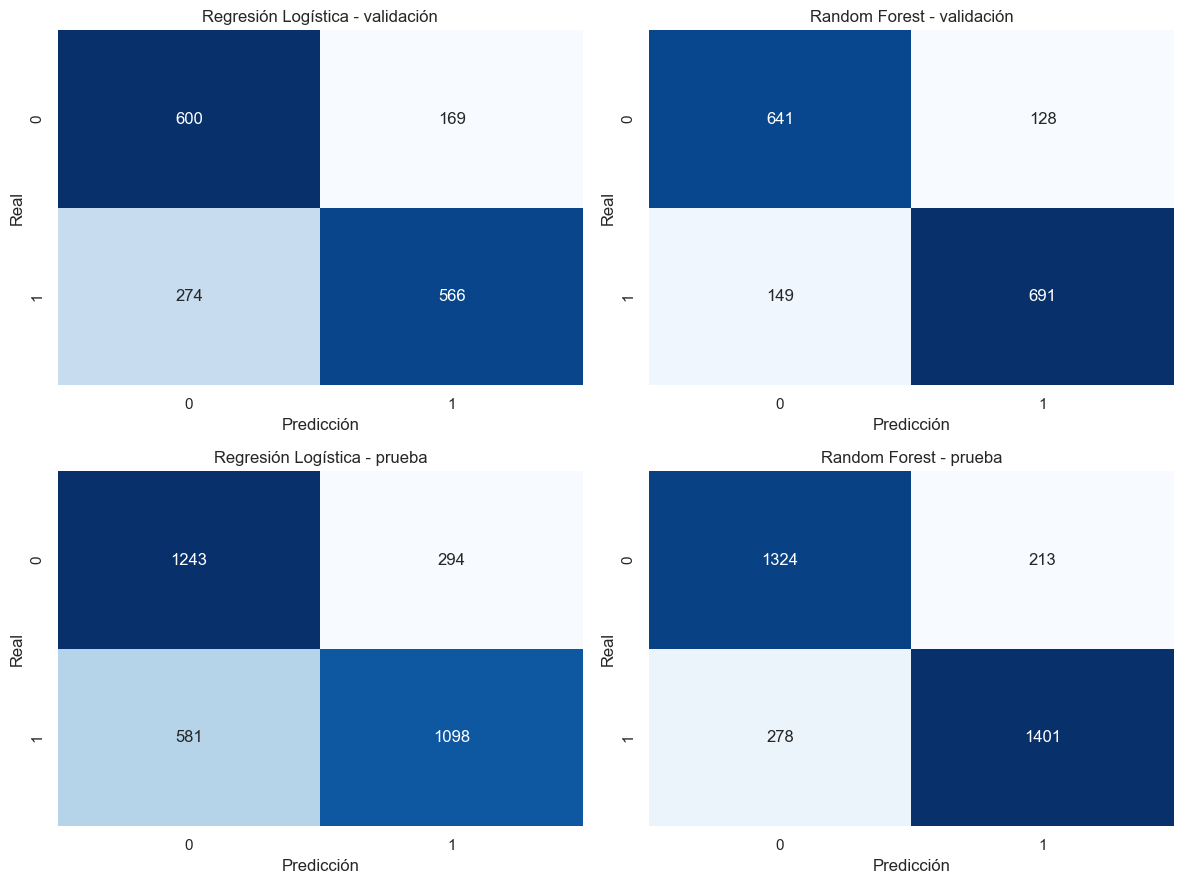

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(12, 9))

model_order = ['Regresión Logística', 'Random Forest']
split_order = ['validación', 'prueba']

for i, split_name in enumerate(split_order):
    for j, model_name in enumerate(model_order):
        ax = axes[i, j]
        cm = results[model_name][split_name]['cm']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
        ax.set_title(f'{model_name} - {split_name}')
        ax.set_xlabel('Predicción')
        ax.set_ylabel('Real')

plt.tight_layout()
plt.show()


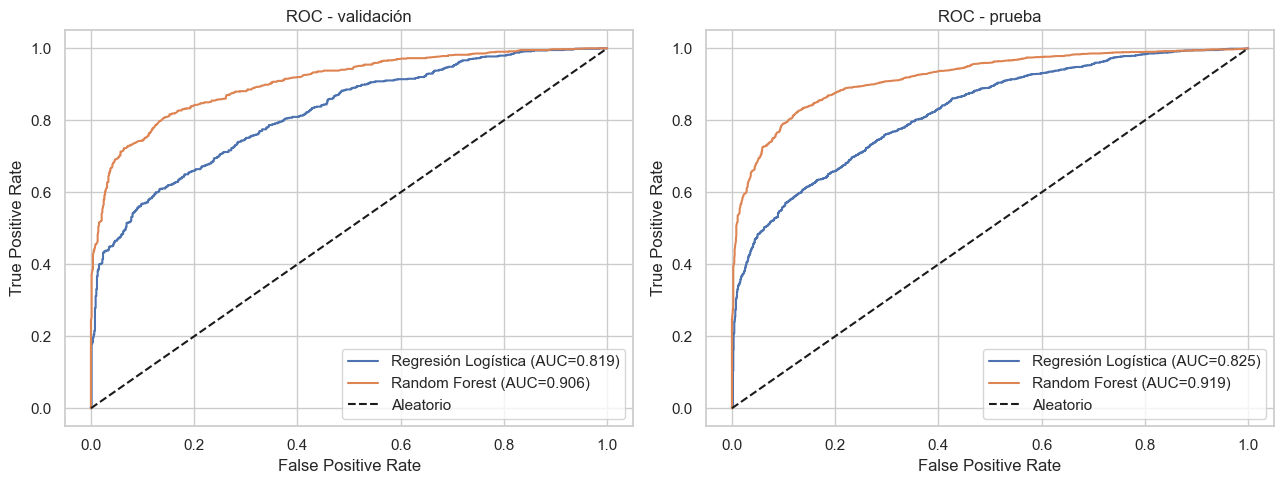

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

for i, split_name in enumerate(['validación', 'prueba']):
    ax = axes[i]
    for model_name in ['Regresión Logística', 'Random Forest']:
        fpr = results[model_name][split_name]['fpr']
        tpr = results[model_name][split_name]['tpr']
        auc = results[model_name][split_name]['auc']
        ax.plot(fpr, tpr, label=f'{model_name} (AUC={auc:.3f})')

    ax.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
    ax.set_title(f'ROC - {split_name}')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend()

plt.tight_layout()
plt.show()


### Observaciones de resultados

A partir de las métricas anteriores:

- El modelo de **Random Forest** logra mayor **recall** y mayor **AUC** que la Regresión Logística tanto en validación como en prueba.
- En este problema, un recall más alto es valioso porque reduce la probabilidad de dejar pasar correos o sitios de phishing como legítimos.
- Ambos modelos son útiles, pero Random Forest muestra una mejor separación entre clases y mejor desempeño global.


In [25]:
val_summary = metrics_df[metrics_df['Dataset'] == 'validación'].copy()
val_summary = val_summary.sort_values(['Recall', 'AUC'], ascending=False).reset_index(drop=True)

best_model_name = val_summary.loc[0, 'Modelo']
best_model = models[best_model_name]

print('Resumen de validación (ordenado por Recall y AUC):')
display(val_summary.round(4))
print()
print(f'Mejor modelo seleccionado: {best_model_name}')


Resumen de validación (ordenado por Recall y AUC):


,Modelo,Dataset,Precision,Recall,AUC,TN,FP,FN,TP
0,Random Forest,validación,0.8437,0.8226,0.9059,641,128,149,691
1,Regresión Logística,validación,0.7701,0.6738,0.8191,600,169,274,566



Mejor modelo seleccionado: Random Forest


### Discusión

**4. ¿Cuál es el impacto de clasificar un sitio legítimo como phishing?**

Genera falsos positivos. En la práctica, bloquea o alerta sobre sitios válidos, lo que puede interrumpir el trabajo de usuarios, aumentar fricción operativa y disminuir la confianza en el sistema de detección.

**5. ¿Cuál es el impacto de clasificar un sitio de phishing como legítimo?**

Genera falsos negativos. Es el error más crítico en ciberseguridad, porque permite que un ataque pase desapercibido, con riesgo de robo de credenciales, fraude y compromiso de activos.

**6. En base a las respuestas anteriores, ¿qué métrica elegiría para comparar modelos similares?**

La métrica principal debe ser **Recall de la clase phishing**, porque prioriza capturar la mayor cantidad posible de ataques reales. Como complemento, se debe monitorear Precision para controlar falsas alarmas.

**7. ¿Qué modelo funcionó mejor para la clasificación de phishing? ¿Por qué?**

El mejor modelo fue **Random Forest**, ya que obtuvo mejor Recall y AUC en validación y prueba, lo que indica mayor capacidad para detectar phishing y una mejor discriminación global entre clases.


### Pregunta 8: Escenario de negocio (50,000 correos, 15% phishing)
Se estima la operación del mejor modelo en un volumen real de correos, utilizando las tasas observadas en el conjunto de prueba.


In [26]:
N_EMAILS = 50000
PREVALENCIA = 0.15

phishing_reales = int(N_EMAILS * PREVALENCIA)
legitimos_reales = N_EMAILS - phishing_reales

cm_test = results[best_model_name]['prueba']['cm']
tn, fp, fn, tp = cm_test.ravel()

# Tasas observadas en prueba
recall_test = tp / (tp + fn)       # Sensibilidad (TPR)
specificity_test = tn / (tn + fp)  # Especificidad (TNR)
fpr_test = 1 - specificity_test

# Proyección a 50,000 correos
TP_est = round(recall_test * phishing_reales)
FN_est = phishing_reales - TP_est
FP_est = round(fpr_test * legitimos_reales)
TN_est = legitimos_reales - FP_est

alarmas_positivas = TP_est + FP_est
alarmas_negativas = TN_est + FN_est

escenario_df = pd.DataFrame({
    'Tipo': ['TP (phishing detectado)', 'FP (falsa alarma)', 'TN (legítimo correcto)', 'FN (phishing omitido)'],
    'Cantidad estimada': [TP_est, FP_est, TN_est, FN_est]
})

print(f'Modelo usado: {best_model_name}')
print(f'Alarmas positivas totales: {alarmas_positivas}')
print(f'Predicciones negativas totales: {alarmas_negativas}')
print(f'Precision estimada en operación: {TP_est / alarmas_positivas:.4f}')
print(f'Recall estimado en operación: {TP_est / phishing_reales:.4f}')
print(f'Falsas alarmas esperadas (FP): {FP_est}')

escenario_df


Modelo usado: Random Forest
Alarmas positivas totales: 12148
Predicciones negativas totales: 37852
Precision estimada en operación: 0.5151
Recall estimado en operación: 0.8344
Falsas alarmas esperadas (FP): 5890


,Tipo,Cantidad estimada
0,TP (phishing detectado),6258
1,FP (falsa alarma),5890
2,TN (legítimo correcto),36610
3,FN (phishing omitido),1242


,Threshold,Recall_estimado,Precision_muestra,FP_estimadas,Alarmas_positivas_estimadas
0,0.50,0.835600,0.866584,5973,12240
1,0.55,0.812400,0.882848,5005,11098
2,0.60,0.774800,0.900346,3982,9793
3,0.65,0.743333,0.912948,3291,8866
4,0.70,0.706400,0.930926,2433,7731
5,0.75,0.661733,0.944728,1797,6760
6,0.80,0.612800,0.958101,1244,5840
7,0.85,0.539067,0.977322,581,4624
8,0.90,0.434133,0.989145,221,3477
9,0.95,0.302000,0.992172,111,2376


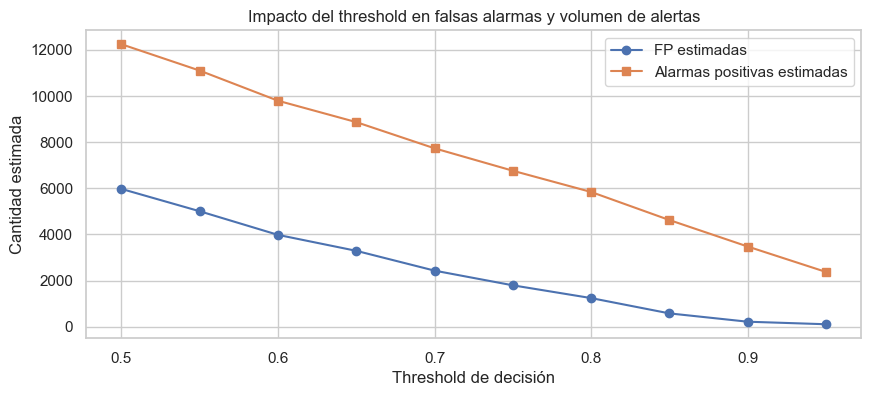

In [27]:
# Análisis de umbral para reducir falsas alarmas
probs_test = best_model.predict_proba(X_test)[:, 1]

threshold_rows = []
for threshold in np.arange(0.50, 0.96, 0.05):
    pred_thr = (probs_test >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, pred_thr).ravel()

    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)

    tp_est = round(tpr * phishing_reales)
    fp_est = round((1 - tnr) * legitimos_reales)

    threshold_rows.append({
        'Threshold': round(threshold, 2),
        'Recall_estimado': tp_est / phishing_reales,
        'Precision_muestra': tp / (tp + fp) if (tp + fp) > 0 else 0,
        'FP_estimadas': fp_est,
        'Alarmas_positivas_estimadas': tp_est + fp_est
    })

threshold_df = pd.DataFrame(threshold_rows)
display(threshold_df)

plt.figure(figsize=(10, 4))
plt.plot(threshold_df['Threshold'], threshold_df['FP_estimadas'], marker='o', label='FP estimadas')
plt.plot(threshold_df['Threshold'], threshold_df['Alarmas_positivas_estimadas'], marker='s', label='Alarmas positivas estimadas')
plt.title('Impacto del threshold en falsas alarmas y volumen de alertas')
plt.xlabel('Threshold de decisión')
plt.ylabel('Cantidad estimada')
plt.legend()
plt.show()


**Respuesta de la pregunta 8:**
Una empresa desea utilizar su mejor modelo, debido a que sus empleados sufren constantes ataques de phishing mediante e-mail. La empresa estima que, de un total de 50,000 emails, un 15% son phishing. ¿Qué cantidad de alarmas generaría su modelo? ¿Cuántas positivas y cuantas negativas? ¿Funciona el modelo para el BR propuesto? En caso negativo, ¿qué propone para reducir la cantidad de falsas alarmas?

- Con el umbral base (0.50), el modelo genera una cantidad considerable de alarmas positivas, incluyendo falsas alarmas.
- El modelo **sí puede funcionar** para el problema de negocio porque detecta una alta proporción de phishing, pero puede generar fatiga operativa por el volumen de alertas.
- Para reducir falsas alarmas se recomienda:
  1. Ajustar el **threshold** de clasificación según la capacidad operativa del equipo de seguridad.
  2. Implementar una estrategia de **doble etapa** (modelo automático + revisión humana para casos dudosos).
  3. Re-entrenar con datos más recientes y aplicar calibración de probabilidades para mejorar el balance entre recall y precision.
